* Aqui vamos gerar a base de dados sintética que será usada.

In [1]:
# imports e setup 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

os.makedirs("../data", exist_ok=True)

In [2]:
# parâmetros e rng
rng = np.random.default_rng(42) # seed fixa
n = 1200 # número de clientes

In [3]:
# gerando as variáveis base
renda = np.exp(rng.normal(7.6, 0.45, n)).round() # ~R$2k-6k
limite = (renda * rng.uniform(0.25, 0.8, n)).round(-2) # limite atual proporcional à renda e com variação
utilizacao = np.clip(rng.beta(2, 3, n), 0, 1) # utilização do limite de 0 a 1 com maioria entre 0.2 e 0.8
consistencia = rng.integers(0, 7, n) / 6 # consistência dos depósitos nos últimos 6 meses
ticket = (renda * rng.uniform(0.05, 0.2, n) * rng.normal(1, 0.1, n)).clip(0) # ticket médio de depósito 5-20% da renda com ruído
atraso = rng.binomial(1, p=np.where(utilizacao > 0.8, 0.25, 0.05), size=n) # probabilidade maior de atraso se utilização > 0.8

* Por que essas escolhas?
    - Renda (lognormal): a maioria ganha menos e a minoria ganha mais.
    - Limite: fração da renda
    - Utilização: maioria usa parcialmente (nem 0% e nem 100%)
    - Consistência: mede o hábito de poupar dos clientes
    - Ticket: valor depositado por mês relativo à renda
    - Atraso: quem usa demais o limite tende a atrasar mais

In [13]:
# criando score (quanto maior, mais risco)
score = (
    0.8 * utilizacao # mais uso
    + 0.6 * (1 - consistencia) # pouca poupança
    + 0.4 * atraso # mais atrasos
    + 0.2 * (limite / renda > 0.7) # limite alto em comparação à renda
)

# calibrando PD para taxa-alvo
target_rate = 0.08
slope = 3.0

# busca binária do viés para atingir média desejada
lo, hi = -10.0, 10.0
for _ in range(60):
    mid = (lo + hi) / 2
    pd_try = 1 / (1 + np.exp(-(mid + slope*score)))
    if pd_try.mean() > target_rate:
        hi = mid
    else:
        lo = mid
bias = (lo + hi) / 2
pd_true = 1 / (1 + np.exp(-(bias + slope*score)))
default = rng.binomial(1, p=pd_true)  

In [14]:
# montando dataframe
df = pd.DataFrame({
    "cliente_id": np.arange(1, n+1),
    "renda_mensal": renda.astype(float),
    "limite_atual": limite.astype(float),
    "utilizacao": utilizacao.astype(float),
    "consistencia_6m": consistencia.astype(float),
    "ticket_medio_deposito": ticket.astype(float),
    "atraso30d": atraso.astype(int),
    "default_12m": default.astype(int)
})

# amostra
df.head()

,cliente_id,renda_mensal,limite_atual,utilizacao,consistencia_6m,ticket_medio_deposito,atraso30d,default_12m
0,1,2292.0,800.0,0.062993,0.833333,322.316757,0,0
1,2,1251.0,600.0,0.206490,0.833333,87.121860,0,0
2,3,2801.0,1000.0,0.275449,0.500000,155.198644,0,0
3,4,3051.0,1000.0,0.325334,1.000000,386.997741,0,0
4,5,831.0,600.0,0.580243,1.000000,58.996221,0,0


In [15]:
# salvando o csv
csv_path = "../data/base_sintetica.csv"
df.to_csv(csv_path, index=False)
print(f"csv salvo em: {csv_path}")

csv salvo em: ../data/base_sintetica.csv


In [16]:
# checagem de sanidade
print("\nSanidade:")
print("  Linhas:", len(df))
print("  Taxa de default_12m:", round(df['default_12m'].mean(), 3))
print("  Consistência média (6m):", round(df['consistencia_6m'].mean(), 3))
print("  Utilização média:", round(df['utilizacao'].mean(), 3))
print("  Limite/Renda média:", round((df['limite_atual']/df['renda_mensal']).mean(), 3))


Sanidade:
  Linhas: 1200
  Taxa de default_12m: 0.092
  Consistência média (6m): 0.499
  Utilização média: 0.396
  Limite/Renda média: 0.526


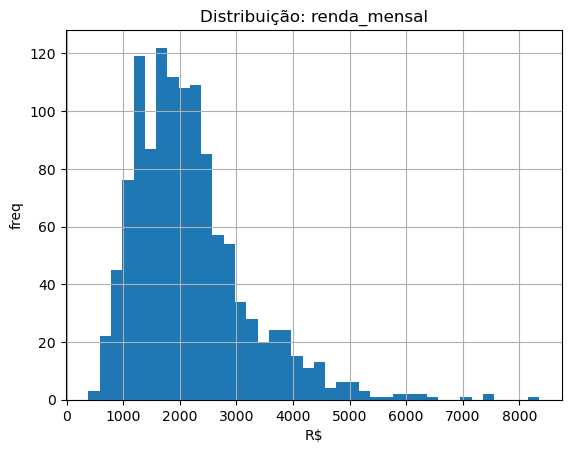

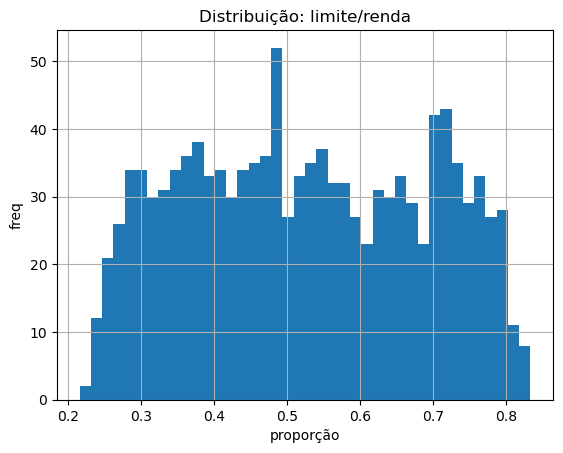

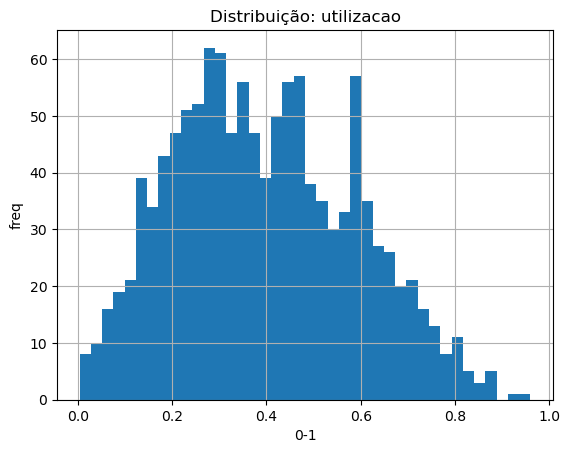

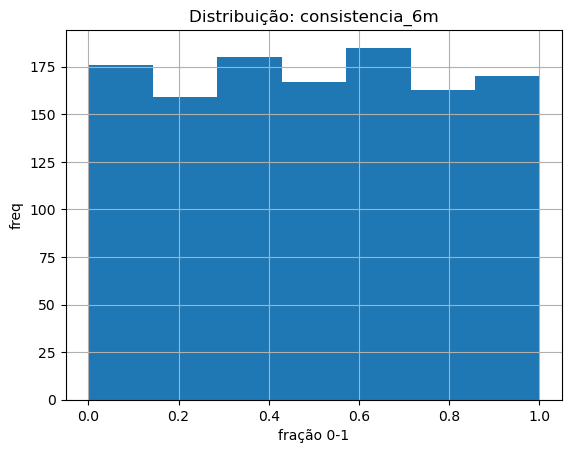

In [17]:
# gráficos simples
plt.figure(); df['renda_mensal'].hist(bins=40); plt.title('Distribuição: renda_mensal'); plt.xlabel('R$'); plt.ylabel('freq'); plt.show()
plt.figure(); (df['limite_atual']/df['renda_mensal']).hist(bins=40); plt.title('Distribuição: limite/renda'); plt.xlabel('proporção'); plt.ylabel('freq'); plt.show()
plt.figure(); df['utilizacao'].hist(bins=40); plt.title('Distribuição: utilizacao'); plt.xlabel('0-1'); plt.ylabel('freq'); plt.show()
plt.figure(); df['consistencia_6m'].hist(bins=7); plt.title('Distribuição: consistencia_6m'); plt.xlabel('fração 0-1'); plt.ylabel('freq'); plt.show()

In [18]:
# correlação simples com o rótulo
print("\nCorrelação com default_12m (maior = mais associado ao calote no sintético):")
print(df.corr(numeric_only=True)['default_12m'].sort_values(ascending=False))


Correlação com default_12m (maior = mais associado ao calote no sintético):
default_12m              1.000000
utilizacao               0.131222
atraso30d                0.128122
cliente_id               0.048795
limite_atual             0.037859
renda_mensal             0.002125
ticket_medio_deposito   -0.006088
consistencia_6m         -0.176110
Name: default_12m, dtype: float64
